# The Battle of Neighborhoods

## 1. Introduction/Business Problem

#### There are many people who are working in various cities (say New York and Toronto) across the world. Let's say a person got a job offer from a great company with great career prospects in another city or other borough of his/her current city. If the person accepts the job offer then he/she has to shift to the new location. I think a person would love to shift to a location which is exactly or almost similar to his/her last location because of the great amenities and other types of venues that exist in his/her current neighbourhood  (school, gym, swimming pool, amusement park, restaurants, coffee-shops, spencer etc). So I’ll find out which borough-neighbourhoods are very similar to his/her current location. A person can shift within the city or from one city to another city. If person is shifting within the city then he/she must be changing the borough and my task would be finding neighbourhoods in that borough which are very similar to his/her last location. If a person is shifting from one city to another city then my task would be finding the similar neighbourhoods.

In [1]:
pip install geopy

     |████████████████████████████████| 112kB 12.4MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib_venn

  Stored in directory: /home/jupyterlab/.cache/pip/wheels/c5/9c/ac/77b0c9151c4c264bec6ba18120d73bb24df5b4c1f09c17a41c
Successfully built matplotlib-venn
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install "ipython-beautifulsoup[bs4]"

     |████████████████████████████████| 122kB 7.3MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import json, requests
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim
import folium 
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib_venn import venn2
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans

# 2.1 Reading the Data

## 2.1.1 New York Data

#### I’ll be using the borough and neighbourhood data of two cities. My first city would be New York and data of this can be downloaded from this link. This data would be json format and it can be very easily transformed into pandas dataframe.I would take only those are important for me like borough, neighbourhood, latitude and longitude.

In [5]:
with open('newyork_data.json') as f:
    ny_json = json.load(f)

# relevant information is in 'features' key
ny_json = ny_json['features']
ny_json[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [6]:
# let's make empty dataframe and put the useful information of json data into dataframe
cols = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude']
ny_df = pd.DataFrame(columns = cols)
for data in ny_json:
    borough = data['properties']['borough']
    neigh   = data['properties']['name']
    lat_lon = data['geometry']['coordinates'] # now it'll return list
    lon, lat = lat_lon[0], lat_lon[1]
    
    ny_df = ny_df.append({'Borough': borough,'Neighbourhood': neigh, 'Latitude': lat,
                          'Longitude': lon}, ignore_index=True)
    
ny_df.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## 2.1.2 Toronto Data

#### Second data of Toronto city can not be directly downloaded. Postal Code, borough and neighbourhood can be scrapped from wikipedia page. There are some rows where “Not assigned” is written. Drop the rows where borough is “Not assigned” (only). If Neighbouthood is 'Not assigned' but Borough is assigned then make corresponding Borough as Neighbourhood. Merge the rows if Postal Code and Borough of two or more rows sameand merged neighbourhood will be separated by comma “,”. Latitude and longitude information can be downloaded from here. Finally this data and Toronto data can be merged together. Once both data are ready we’ll use Foursquare API to get the venues near each neighbourhood. To get the nearby venues data we must have Foursquare account and app which will give the credentials.

In [7]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source)
table_data = soup.find('div', class_='mw-parser-output')
table = table_data.table.tbody
columns = ['Postal Code', 'Borough', 'Neighbourhood']
data = dict({key:[]*len(columns) for key in columns})
for row in table.find_all('tr'):
    for i,column in zip(row.find_all('td'),columns):
        i = i.text
        i = i.replace('\n', '')
        data[column].append(i)
toronto_df = pd.DataFrame.from_dict(data=data)[columns]
print("Before dropping the 'Not assigned' rows, shape is: ",toronto_df.shape)
toronto_df = toronto_df[toronto_df['Borough'] != 'Not assigned'].reset_index(drop = True)
print('After dropping rows where borough is "Not assigned", Shape is: ',toronto_df.shape)
print('Number of rows where Neighbourhood is "Not assigned" but borough has value: ', 
      toronto_df[toronto_df['Neighbourhood'] == 'Not assigned'].shape[0])
# making corresponding Borough as Neighbourhood: where Neighbourhood is 'Not assigend'
p, b, n = [], [], []
for postcode, borough, neigh in zip(toronto_df['Postal Code'], toronto_df['Borough'], toronto_df['Neighbourhood']):
    p.append(postcode)
    b.append(borough)
    if neigh == 'Not assigned':
        n.append(borough)
    else:
        n.append(neigh)
toronto_df = pd.DataFrame({'Postal Code': p, 'Borough': b, 'Neighbourhood':n})[columns]

# merging the rows, where Postal Code and Borough is same and Neighbourhoods will be seperated by ','
# :https://stackoverflow.com/a/27298308
toronto_df = toronto_df.groupby(['Postal Code', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
print('Before Adding the latitude and longitue, shape is: ',toronto_df.shape)


lat_lon = pd.read_csv("https://cocl.us/Geospatial_data")
# merging the latitude and longitude
print("\nColumns of latlon are: {},\nSo merging on '{}'".format(lat_lon.columns, lat_lon.columns[0]))
toronto_df = pd.merge(toronto_df, lat_lon, how= 'inner', on = 'Postal Code')
print('Final Shape of data is: ', toronto_df.shape)

Before dropping the 'Not assigned' rows, shape is:  (180, 3)
After dropping rows where borough is "Not assigned", Shape is:  (103, 3)
Number of rows where Neighbourhood is "Not assigned" but borough has value:  0
Before Adding the latitude and longitue, shape is:  (103, 3)

Columns of latlon are: Index(['Postal Code', 'Latitude', 'Longitude'], dtype='object'),
So merging on 'Postal Code'
Final Shape of data is:  (103, 5)


In [8]:
toronto_df.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


## 2.2 Getting Venues Using Foursquare API

In [9]:
CLIENT_ID = 'VX3QIBY0VVYW1RLPVI2YBJPEWITP11HQNARLMFSGNIRN1DFE' # your Foursquare ID
CLIENT_SECRET = '3A4YZ0YMW4IBLVSBEIZLX2DVUKQRPDPB1PV1ETYJDEJ0LPMU'
VERSION = '20180605' # Foursquare API version
LIMIT = 100

In [10]:
def get_near_by_venues(names, latitudes, longitudes, radius= 1000):    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)    

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, 
                             v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ['Neighbourhood','Neighbourhood Latitude', 'Neighbourhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return nearby_venues

In [11]:
def explore_borough(df, borough):
    new_df = df[df['Borough'] == borough].reset_index(drop = True)
    venues =  get_near_by_venues(names = new_df['Neighbourhood'],latitudes = new_df['Latitude'],
                                 longitudes = new_df['Longitude'])

    onehot_df = pd.get_dummies(venues[['Venue Category']], prefix= "", prefix_sep= "")

    # # add neighborhood column back to dataframe
    onehot_df['Neighbourhood'] = venues['Neighbourhood']
    # move neighborhood column to the first column
    fixed_columns = [onehot_df.columns[-1]] + list(onehot_df.columns[:-1])
    onehot_df = onehot_df[fixed_columns]
    onehot_df_grouped = onehot_df.groupby('Neighbourhood').mean().reset_index()
    
    onehot_coded_df = pd.merge(new_df, onehot_df_grouped, on = 'Neighbourhood', how = 'left')
    
    return onehot_coded_df

In [12]:
def return_venues_for_boroughs(df):
    col = list(df.columns)
    all_venues = pd.DataFrame()
    for i in df['Borough'].unique():
        new_df = df[df['Borough'] == i]
        print('For borough: ',i)
        a = explore_borough(new_df, i)
        all_venues = pd.concat([a, all_venues], axis = 0, ignore_index = True, sort = True)
    cols = col + [j for j in all_venues.columns if j not in col]
    all_venues = all_venues[cols]
    return all_venues

## 2.2.1 For New York City

In [13]:
try:
    df1 = pd.read_csv('New_York_venue.csv')
except:
    df1 = return_venues_for_boroughs(ny_df)
    df1.fillna(0,  inplace = True)
    df1.to_csv('New_York_venue.csv',  index_label = False)
print('Shape data is: ', df1.shape)
df1.head()

Shape data is:  (306, 480)


,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Rink,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaura

## 2.2.2 For Toronto City

In [14]:
try:
    df2 = pd.read_csv('Toronto_venue.csv')
except:
    df2 = return_venues_for_boroughs(toronto_df)
    df2.fillna(0, inplace = True)
    df2.to_csv('Toronto_venue.csv',  index_label = False)
print('Shape data is: ', df2.shape)
df2.head()

Shape data is:  (103, 338)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsagent,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping

#### - Now our data is ready to process. We've 475 columns in New York data and 339 columns in Toronto city data.
#### - Other than these columns ('Borough', 'Neighbourhood', 'Latitude', 'Longitude') of New York city data are nearby venues of corresponding Neighbourhood.
#### - Other than these columns ('Postal Code', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude',) of Toronto city data are nearby venues of corresponding Neighbourhood.

# 3. Exploratory Data Analysis (EDA)

#### Both dataset have a different number of columns, but many of them are common. Let's find how many of them are common.

#### Note: 'Borough', 'Neighbourhood', and 'Latitude' columns of New York data and 'Postal Code', 'Borough', 'Neighbourhood', and 'Latitude' of Toronto city data will not be counted, when we'll be finding the common columns of both data.

#### Common Venue categories:
#### - Let's find out how many venue categories are common in both cities data.
#### - We'll deal with only common vanue categories data amd rest other venue categories will be dropped.

In [15]:
print('Leaving {} columns of New York city data\nLeaving {} columns of Toronto city data'
      .format(list(df1.columns[0:4]), list(df2.columns[0:5])))
common = 0
diff_in_NY = 0

for i in df1.columns[4:]:
    if i in df2.columns[5:]:
        common += 1
    else:
        diff_in_NY += 1

print('\nNumber of common venue categories in both data are       :{}\n\
Number of different venue categories in New York city are: {}\n\
Number of different venue catehories in Toronto city are : {}'.format(common, diff_in_NY,
                                                                     len(df2.columns[5:])-common))

Leaving ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] columns of New York city data
Leaving ['Postal Code', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude'] columns of Toronto city data

Number of common venue categories in both data are       :301
Number of different venue categories in New York city are: 175
Number of different venue catehories in Toronto city are : 32


#### - Let's visualize them using **Venn** diagram

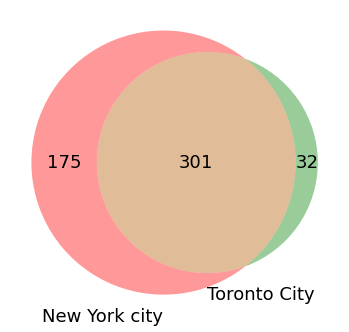

In [16]:
cl1 = set(df1.columns[4:])
cl2 = set(df2.columns[5:])
plt.figure(figsize = (6,6))
out = venn2([set(cl1), set(cl2)], set_labels = ['New York city', 'Toronto City'])
# chnage the text size of matplotlib venn:https://stackoverflow.com/a/29426251
for text in out.set_labels:
    text.set_fontsize(18)
for text in out.subset_labels:
    text.set_fontsize(18)
plt.show()

#### Let's get only the common venue categories of both cities and drop the other categories.

In [17]:
comm_col = []
for i in df1.columns[4:]:
    if i in df2.columns[5:]:
        comm_col.append(i)

col1 = list(df1.columns[0:4]) + comm_col
col2 = list(df2.columns[0:5]) + comm_col
print('Before reomoving non-common shape of New York: {}, and shape of Toronto is: {}'
      .format(df1.shape, df2.shape))
df1 = df1.loc[:, col1]
df2 = df2.loc[:, col2]
print('After reomoving non-common shape of New York: {}, and shape of Toronto is: {}'
      .format(df1.shape, df2.shape))

Before reomoving non-common shape of New York: (306, 480), and shape of Toronto is: (103, 338)
After reomoving non-common shape of New York: (306, 305), and shape of Toronto is: (103, 306)


# 4. Find Most Similar Location in Other City

#### - To find the most similar location, cosine similarity will be used.
#### - This kind of recommendation comes under item-item based recommender system.

#### Consider a person living in Bronx, Riverdale, New York City. Now he/she wants to move to Toronto city for some reason and he/she wants to find the most similar neighborhood to his/her current city. 

#### - We'll be finding only top 7 most similar boroughs.
#### - Find following details of his/her location from above data:
##### - index value
##### - latitude
##### - longitude
##### - venues near this location

In [19]:
def return_ordered_num(n_most_similar):
    a = ['st', 'nd', 'rd']
    c = []
    for i in range(1,20+1):
        if i == 1:
            c.append(str(i)+str(a[i-1]))
        elif i == 2:
            c.append(str(i)+str(a[i-1]))
        elif i == 3:
            c.append(str(i)+str(a[i-1]))
        else:
            c.append(str(i)+'th')
    return c

In [20]:
index = df1.loc[(df1['Borough'] == 'Bronx') 
                & (df1['Neighbourhood'] == 'Riverdale')].index.values.astype(int)[0]
lat = df1.loc[index]['Latitude']
lon = df1.loc[index]['Longitude']
print('Index    :{}\nLatitude : {}\nLongitude: {}'.format(index, lat, lon))

Index    :258
Latitude : 40.890834493891305
Longitude: -73.9125854610857


In [21]:
ny_data = df1.loc[:,comm_col] # selecting only common venues
toronto_data = df2.loc[:,comm_col] # selecting only common venues

# converting into numpy ndarray
X1 = ny_data.values
X2 = toronto_data.values
print('Shape of X1: {}\nShape of X2: {}'.format(X1.shape, X2.shape))

Shape of X1: (306, 301)
Shape of X2: (103, 301)


#### Let's find most similar boroughs by using cosine similarity.

In [24]:
a = np.matmul(X1[index], X2.T)
#return the index in sorted order (descending)of values, 
#first element correspond to the index of maximum value in a
aa = np.argsort(-a)[0:7] 
my_borough = df2.iloc[aa, :]
print(my_borough.shape)
my_borough.head()

(7, 306)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Rest

### Let's visualize similar boroughs using folium.

In [ ]:
# for tooltip of map
c = return_ordered_num(7)

current_location_popup = 'Bronx, Riverdale, New York'
label1 = folium.Popup(current_location_popup, parse_html=True)

my_map = folium.Map(location = [lat, lon], zoom_start = 6)
folium.CircleMarker([lat, lon], color = 'red', radius = 5,
                    popup = label1, fill_color = '#3186cc', fill_opacity = 1,
                    fill = True, tooltip = 'current location').add_to(my_map)

# add markers to map
for lat, lng, label, priority in zip(my_borough['Latitude'], my_borough['Longitude'], 
                                     my_borough['Neighbourhood'], c):
    label = folium.Popup(label, parse_html=True)
    folium.Marker([lat, lng], radius = 5, popup=label, color='blue', 
                  tooltip = priority, parse_html=False).add_to(my_map)
    
my_map

## 6. Function for all steps of 5
#### - This function can be used for both cities. We can find most similar borough in either cities.

In [ ]:
def most_similar_borough(current_city, current_borough, current_neigh, n_most_similar):
    ny_data = df1.iloc[:,4:]
    toronto_data = df2.iloc[:,5:]
    if current_city.lower() == 'New York'.lower():
        X1 = ny_data.values
        X2 = toronto_data.values
        index = df1.loc[(df1['Borough'] == current_borough) 
                        & (df1['Neighbourhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df1.loc[index]['Latitude']
        lon = df1.loc[index]['Longitude']
    else:
        X1 = toronto_data.values
        X2 = ny_data.values
        index = df2.loc[(df2['Borough'] == current_borough) 
                & (df2['Neighbourhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df2.loc[index]['Latitude']
        lon = df2.loc[index]['Longitude']
    
    a = np.matmul(X1[index], X2.T)
    aa = np.argsort(-a)[0:n_most_similar]
    
    if current_city.lower() == 'New York'.lower():
        my_borough = df2.iloc[aa, :]
    else:
        my_borough = df1.iloc[aa, :]
   
    # for tooltip of map
    c = return_ordered_num(n_most_similar)
    
    current_location_popup = '{}, {}, {}'.format(current_neigh, current_borough, current_city)
    label1 = folium.Popup(current_location_popup, parse_html=True)
    
    my_map = folium.Map(location = [lat, lon], zoom_start = 6)
    folium.CircleMarker([lat, lon], color = 'red', radius = 5,
                        popup = label1, fill_color = '#3186cc', fill_opacity = 1,
                        fill = True, tooltip = 'current location').add_to(my_map)

    # add markers to map
    for lat, lng, label, priority in zip(my_borough['Latitude'], my_borough['Longitude'], 
                                         my_borough['Neighbourhood'], c):
        label = folium.Popup(label, parse_html=True)
        folium.Marker([lat, lng], radius = 5, popup=label, color='blue', 
                      tooltip = priority, parse_html=False).add_to(my_map)  

    return my_map

### From New York to Toronto

#### - Current Location: Bronx, Riverdale, New York

In [ ]:
most_similar_borough(current_city = 'New York', current_borough = 'Bronx',
                     current_neigh = 'Riverdale', n_most_similar = 7)

### From New York to Toronto

#### - Current Location: Etobicoke, 'Alderwood, Long Branch', Toronto

In [ ]:
most_similar_borough(current_city = 'Toronto', current_borough = 'Etobicoke',
                     current_neigh = 'Alderwood, Long Branch', n_most_similar = 10)